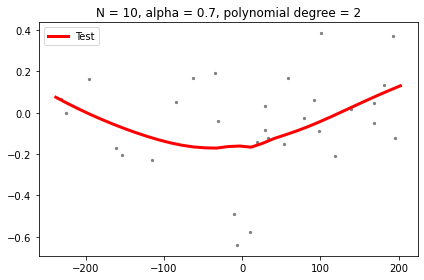

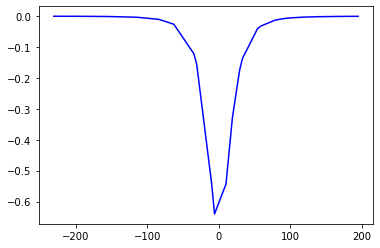

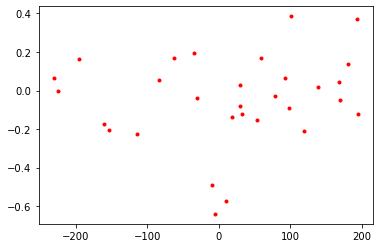

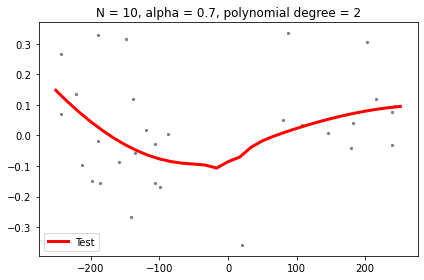

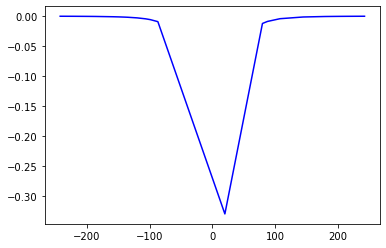

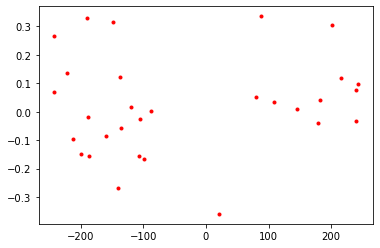

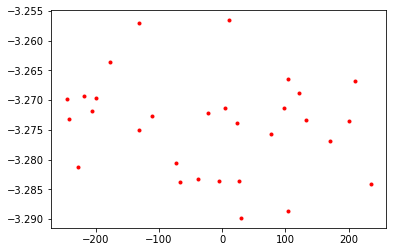

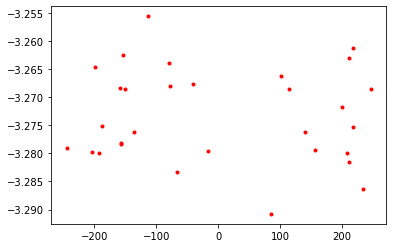

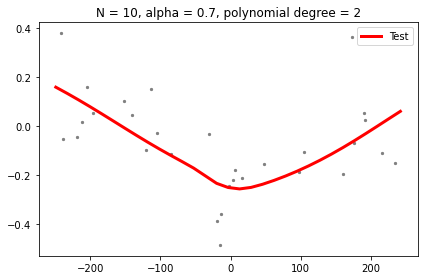

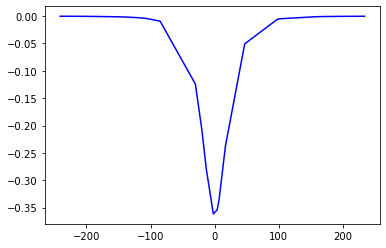

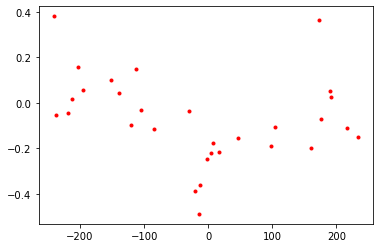

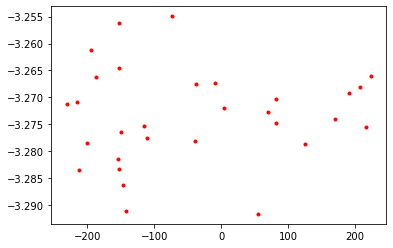

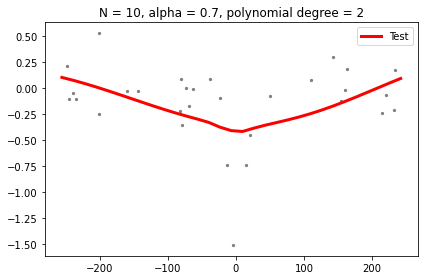

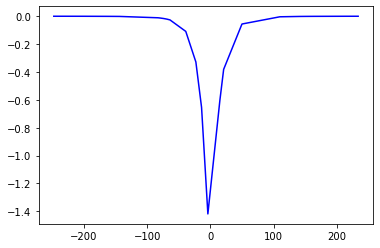

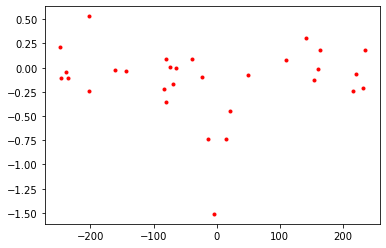

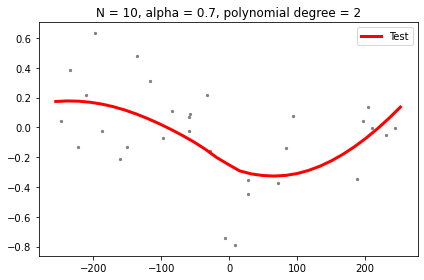

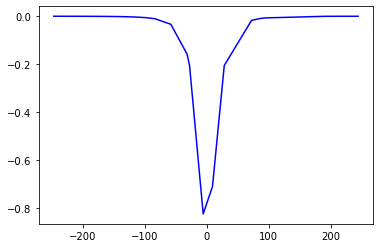

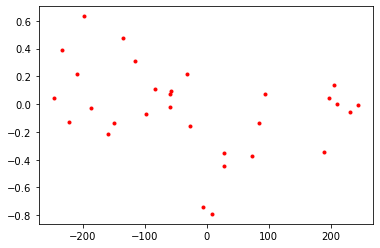

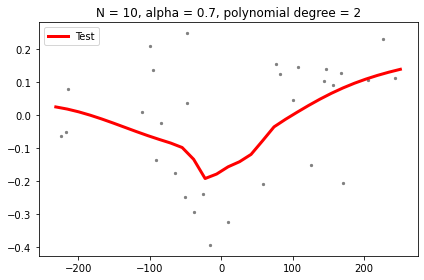

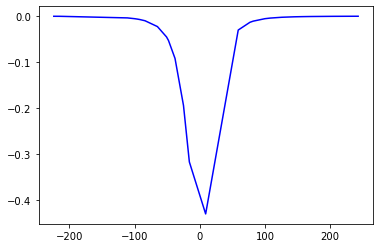

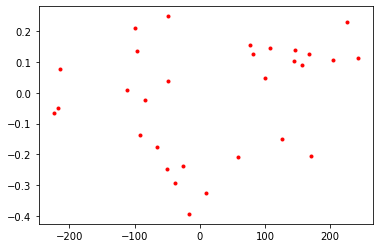

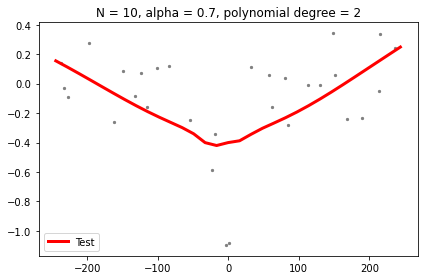

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

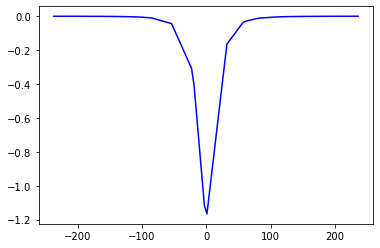

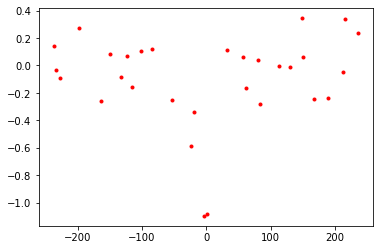

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, skew, kurtosis
from scipy.optimize import curve_fit as fit
import random
import seaborn as sns             # Seaborn for beautiful plots
import statsmodels
import pandas as pd

LCamount = 10
truthlst = np.zeros(LCamount) #Liste gefilterter ML-Events, np.zeros(x) macht Liste mit x Nullen
filternumber = 2
truetruth_lst = np.zeros(LCamount) #Liste mit tatsächlichen ML-Events
truthlst_lowess = []
probability = 2
magpointamount = 30
lclist = [] #stellt synthetischen Datensatz dar
skewlist = [] #Skewness-Werte alles LC
skewlist_lowess = []
stdlist = [] #Standardabw-Werte alles LC
stdlist_lowess = []
filterlst = [] #Index (wie object ID) wird in Liste eingefügt -> am Schluss gezählt, ob alle Kriterien erfüllt
filterlst_lowess = []
tElist = []
uminlist = []
standardlist = []
#Theorie-Parameter:
t0=0 #Zeitpunkt max. Helligkeit
surveylength = 500 #wie lange gesamte Messung dauerte = maximale Eventdauer
standard_deviation = 0.2
mean_skew = -0.22994225279524635  #Mittelwert von 2 fields 
mean_std = 0.15856555  #Mittelwert von 2 fields 
mean_mean = 20.421268  #Mittelwert von 2 fields 
C = 0

for i in range(0, LCamount): #random Lichtkurven werden generiert
    #Produktion von künstlichen Lichtkurven
    l = random.randint(0, 5) #Helligkeit Stern
    p = random.randint(0, probability) #Wahrscheinlichkeit von 1/40

    if p == 1:
        truetruth_lst[i] = 1 #Nullen-Array an x-ter Stelle mit 1 ersetzt -> ML-Event
        # t0=0 #Zeitpunkt max. Helligkeit
        # umin=0.25
        # tE=25 #Zeitdauer, um Einstein-Radius zurückzulegen
        # standard_deviation = 0.2

        t = [] #(start, end, Anz. Striche zwischen start und end) -> x-Achse
        #freie Parameter hängen von t ab -> verändern sich mit der Zeit -> Körper bewegen sich
        a = []
        a1 = []
        standard_deviation = mean_std#random.randint(0,50)/10
        umin = random.random()
        tE = 24#random.randint(1, 1/2*surveylength) #Zeitdauer, um Einstein-Radius zurückzulegen
        #random.uniform() gives random float between given range
        for i in range(magpointamount):
            t.append(random.randint(-(1/2)*surveylength, (1/2)*surveylength))
            t.sort()
        for d in t:  #Helligkeit A abhängig von u, u abhängig t
            u = np.sqrt(umin**2 + ((d-t0)/tE)**2)
            A = (u**2 + 2) / (u*np.sqrt(u**2 + 4)) + random.gauss(0, standard_deviation) #bei beiden Gauss-Rauschen machen
            M = -2.5*np.log10(A) - C
            a.append(M)
            #print("umin: ", umin, "tE: ", tE, "skew: ", skew(a), "std: ", np.std(a))
        for d in t:  #Helligkeit A abhängig von u, u abhängig t
            u = np.sqrt(umin**2 + ((d-t0)/tE)**2)
            A = (u**2 + 2) / (u*np.sqrt(u**2 + 4))
            M = -2.5*np.log10(A) - C
            a1.append(M)
        x_values = t
        y_values = a
        df = pd.DataFrame({"Xvalue" : x_values,
                            "Yvalue" : y_values
                            })

        def loc_eval(x, b):
            loc_est = 0
            for i in enumerate(b): loc_est+=i[1]*(x**i[0])
            return(loc_est)


        def loess(xvals, yvals, data, alpha, poly_degree=1):
            all_data = sorted(zip(data[xvals].tolist(), data[yvals].tolist()), key=lambda x: x[0])
            xvals, yvals = zip(*all_data)
            evalDF = pd.DataFrame(columns=['v','g'])
            n = len(xvals)
            m = n + 1
            q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
            avg_interval = ((max(xvals)-min(xvals))/len(xvals))
            v_lb = min(xvals)-(.5*avg_interval)
            v_ub = (max(xvals)+(.5*avg_interval))
            v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)
            xcols = [np.ones_like(xvals)]
            for j in range(1, (poly_degree + 1)):
                xcols.append([i ** j for i in xvals])
            X = np.vstack(xcols).T
            for i in v:
                iterpos = i[0]
                iterval = i[1]
                iterdists = sorted([(j, np.abs(j-iterval)) for j in xvals], key=lambda x: x[1])
                _, raw_dists = zip(*iterdists)
                scale_fact = raw_dists[q-1]
                scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
                weights = [(j[0],((1-np.abs(j[1]**3))**3 if j[1]<=1 else 0)) for j in scaled_dists]
                _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
                _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
                _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))
                W         = np.diag(weights)
                b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ yvals)
                local_est = loc_eval(iterval, b)
                iterDF2   = pd.DataFrame({
                            'v'  :[iterval],
                            'g'  :[local_est]
                            })
                evalDF = pd.concat([evalDF, iterDF2])
            evalDF = evalDF[['v','g']]
            return(evalDF)


        evalDF = loess("Xvalue", "Yvalue", data = df, alpha=0.9, poly_degree=2)
        skewlist_lowess.append(skew(evalDF))
        stdlist_lowess.append(np.std(evalDF))
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.scatter(df["Xvalue"], df["Yvalue"], color="grey", marker="o", s=5, label="_nolegend_")
        ax1.plot(evalDF['v'], evalDF['g'], color='red', linewidth= 3, label="Test")
        plt.title('N = 10, alpha = 0.7, polynomial degree = 2')
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.figure()
        plt.plot(t, a1, "-", color = "blue")
        plt.figure() #make coordinate system
        plt.plot(t, a,".", color = "red")#t,a = lists! -> A(t)+0.2*random -> adds random number to whole list -> for loop to handle each value separately!
        #plt.plot(noisered[0], noisered[1], "-", color = "blue")
        lclist.append(a)
        tElist.append(tE)
        uminlist.append(umin)
        standardlist.append(standard_deviation)
    if p != 1: 
        
        t = [] #(start, end, Anz. Striche zwischen start und end) -> x-Achse
        #freie Parameter hängen von t ab -> verändern sich mit der Zeit -> Körper bewegen sich
        a = []
        for i in range(magpointamount):
            t.append(random.randint(-(1/2)*surveylength, (1/2)*surveylength))
            t.sort()
        for d in t:
            A = mean_mean + random.gauss(0, standard_deviation)
            M = -2.5*np.log10(A) - C
            a.append(M)
        lclist.append(a)
        plt.figure() #make coordinate system
        plt.plot(t, a,".", color = "red")#t,a = lists! -> A(t)+0.2*random -> adds random number to whole list -> for loop to handle each value separately!

for lc in lclist:
    skewlist.append(skew(lc))
    stdlist.append(np.std(lc))

    
for i in skewlist:
    if i < mean_skew : #Minus weil sonst zu streng, lieber zu viel erkannt als eine nicht erkannt -> garantiert keine ML gehen verloren (wahrscheinlich doch unnötig nach Überprüfung, doch mal beibehalten)
        filterlst.append(skewlist.index(i))
for i in stdlist:
    if i > mean_std: #np.std weil dann individuell angepasster
        filterlst.append(stdlist.index(i))
    #Standardabweichung
for i in skewlist_lowess:
    if i < mean_skew:
        filterlst_lowess.append(skewlist_lowess.index(i))
for i in stdlist_lowess:
    if i > mean_std:
        filterlst_lowess.append(stdlist_lowess.index(i))
        

if np.count_nonzero(truetruth_lst == 0) != LCamount: #if no ML-Event -> false trues
    for i in range(LCamount): 
        if filterlst.count(i) == filternumber: #hat jeweiliger Index i alle Tests bestanden?
            truthlst[i] = 1 # Lichtkurve an gewisser Stelle alle Filter bestanden -> gleiche Stelle in truthlst mit 1 markieren
        if filterlst_lowess.count(i) == filternumber:
            truthlst_lowess[i] = 1


lost = []
trap = []
found = []
tE_ls = []
umin_ls = []
std_ls = []
stdsuccess = []

lostlow = []
traplow = []
foundlow = []

for i in range(LCamount):
    if truthlst[i] != truetruth_lst[i]:
        if truthlst[i] - truetruth_lst[i] < 0: #wenn ML verloren ging
            lost.append(1)
        else:
            trap.append(1) #angebliches ML
    elif truthlst[i] + truetruth_lst[i] == 2.0:
        found.append(1)
        if i <= len(tElist):
            tE_ls.append(tElist[i])
            umin_ls.append(uminlist[i])
            std_ls.append(standardlist[i])

for i in range(LCamount):
    if truthlst_lowess[i] != truetruth_lst[i]:
        if truthlst_lowess[i] - truetruth_lst[i] < 0: #wenn ML verloren ging
            lost.append(1)
        else:
            trap.append(1) #angebliches ML
    elif truthlst_lowess[i] + truetruth_lst[i] == 2.0:
        found.append(1)
        if i <= len(tElist):
            tE_ls.append(tElist[i])
            umin_ls.append(uminlist[i])
            std_ls.append(standardlist[i])

for i in std_ls:
    stdsuccess.append(std_ls.count(i))


#print("TEST (-> Fehlversuch falls 0): ", np.count_nonzero(truthlst == 1))#?????
if np.count_nonzero(truthlst == 1) != 0: #wenn kein sog "Fehlversuch"
    plt.figure() 
    plt.plot(tE_ls, umin_ls,".", color = "green")
    plt.figure() 
    plt.plot(std_ls, stdsuccess,".", color = "green")
    print("*************************OHNE Lowess***********************")
    print("verlorene ML: ", len(lost))
    print("scheinbare ML: ", len(trap))
    print("gefundene ML: ", len(found))
    print(truetruth_lst)
    print(truthlst)
    print(tE_ls)
    print(umin_ls)
    print("*************************MIT Lowess***********************")
    print("verlorene ML: ", len(lostlow))
    print("scheinbare ML: ", len(traplow))
    print("gefundene ML: ", len(foundlow))
    print(truetruth_lst)
    print(truthlst_lowess)
    


else:
    print("Noch nicht verstandener scheinbarer Fehlversuch. Nochmal ausführen bis es klappt.")

    #Gritsearch